<table><tr><td height="250" width="500"><img src="https://www.opendataportal.at/wp-content/uploads/2016/09/WU-Wien-Logo.png"/ height="250" width="500"></td><td height="250" width="250"><img src="https://beta.ownyourdata.eu/wp-content/uploads/2018/02/logo512-300x300.png" height="250" width="250"/></td></tr></table>
<hr>
<h1><center>Data Science Lab: Own Your Data </center></h1>
<hr>
<h2><center>Notebook 2: Data Recording Visualisations </center></h2>

<h5> Importing neccessary modules

In [66]:
import json
import pandas as pd
pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt
import datetime
import numpy as np
import geopy
import geopy.geocoders
from geopy.geocoders import Nominatim

<h5>Importing neccessary formulas

<h6>The Haversine formula is used to calculate the distance between two coordinate pairs

In [67]:
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return (m)

<h6>The formulas used in notebook 1 to convert between coordinates and addresses will be used

In [68]:
def get_city(lat, lon):
    geolocator = Nominatim(user_agent="just-searching-some-addresses")
    coordinate = ", ".join((str(lat),str(lon)))
    location = geolocator.reverse(coordinate, addressdetails = False, language = "en")
    location_list = str(location).split(", ")
    city = location_list[-3]
    country = location_list[-1]
    return(city, country, location)
def get_coordinates(x):
    geolocator = Nominatim(user_agent="reverse-searching-to-coordinates")
    location = geolocator.geocode(x)
    return(location)

<h5> Setting filepath

In [69]:
filepath = "./data/user_archive_091118"

<h5> Format Data

In [70]:
with open (filepath, "r") as file:
    all_data = json.load(file)
data = all_data["data"]
for dictionary in data:
    if "Location" in dictionary.keys():
        gps_data = dictionary["Location"]
gps = pd.DataFrame(gps_data)

<h5> Creating a dataframe to inspect the time at which it was recorded

In [71]:
occurence = gps[["timestamp"]]
occurence["time"] =  pd.to_datetime(occurence["timestamp"], format="%Y-%m-%dT%H:%M:%S.%fZ")
occurence = occurence.drop("timestamp", axis=1)

<h5> Storing the hourly frequencies in a variable

In [72]:
plot_data = occurence.groupby(occurence["time"].dt.hour).count()

<h5> Creating a graph

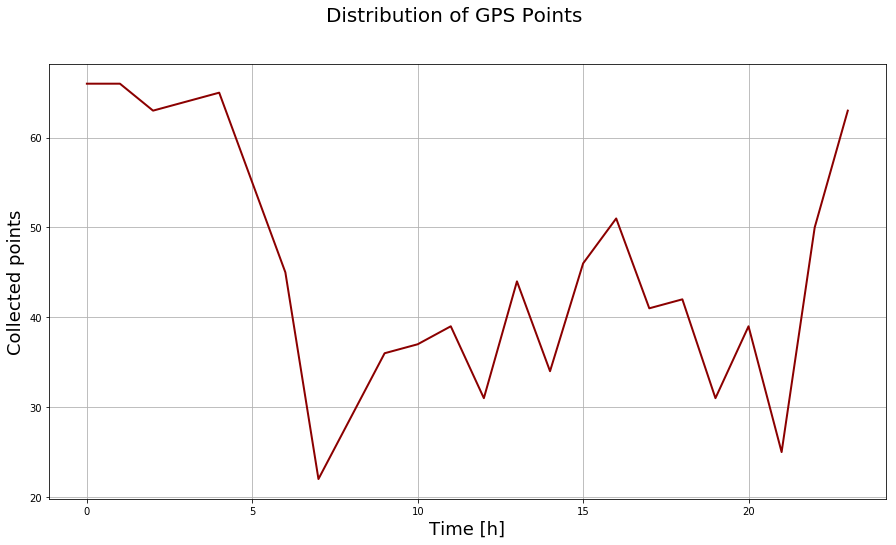

In [73]:
fig = plt.figure(figsize=(15, 8))
line = plt.plot(plot_data)
plt.setp(line, color = "darkred", linewidth=2)
fig.suptitle("Distribution of GPS Points", fontsize=20)
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("Collected points", fontsize=18)
plt.grid()
plt.show()

In [74]:
gps["datetime"] = pd.to_datetime(gps["timestamp"], format="%Y-%m-%dT%H:%M:%S.%fZ")
gps["date"] = gps["datetime"].dt.date
records_per_day = gps["date"].groupby(gps["date"]).count()

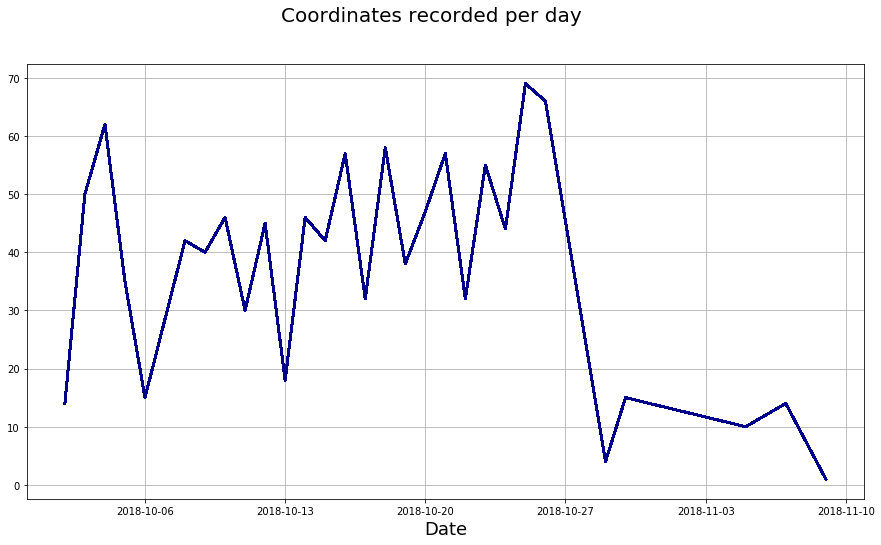

In [92]:
fig = plt.figure(figsize=(15, 8))
line, = plt.plot(records_per_day)
line.set_antialiased(False)
plt.setp(line, color = "darkblue", linewidth=2)
fig.suptitle("Coordinates recorded per day", fontsize=20)
plt.xlabel("Date", fontsize=18)
plt.grid()
plt.show()

<h5> Creating a dataframe to check for the distance between the data records

In [78]:
coordinates = gps[["latitude", "longitude", "timestamp"]]

<h5>Processing the dataframe</h5><br><br>
<ol>
    <li>Sorting the elements by date</li>
    <li>Calculating the distance to the previous record</li>
    <li>Converting the timestamp to datetime object</li>
    <li>Dropping the timestamp column</li>
    <li>Calculating the time delta to the last entry</li>
</ol>

In [79]:
coordinates = coordinates.sort_values(by = "timestamp").reset_index(drop=True)
coordinates["last_latitude"] = coordinates["latitude"].shift(1)
coordinates["last_longitude"] = coordinates["longitude"].shift(1)
coordinates["distance in km"] = haversine_np(lon1 = coordinates["last_longitude"], 
                                                         lat1 = coordinates["last_latitude"],
                                                        lon2 = coordinates["longitude"],
                                                        lat2 = coordinates["latitude"]) /1000

coordinates["time"] =  pd.to_datetime(coordinates["timestamp"], format="%Y-%m-%dT%H:%M:%S.%fZ")
coordinates["last_time"] = coordinates["time"].shift(1)
coordinates["interval"] = coordinates["time"] - coordinates["last_time"]
coordinates["distance in km"] = coordinates["distance in km"].fillna(0)

<h5>Creating a plot of the distance between coordinate points

In [80]:
distance = coordinates["distance in km"]
x = [i for i in range(1,len(distance)+1)]
y = distance
y = y.fillna(0)
y = y.tolist()

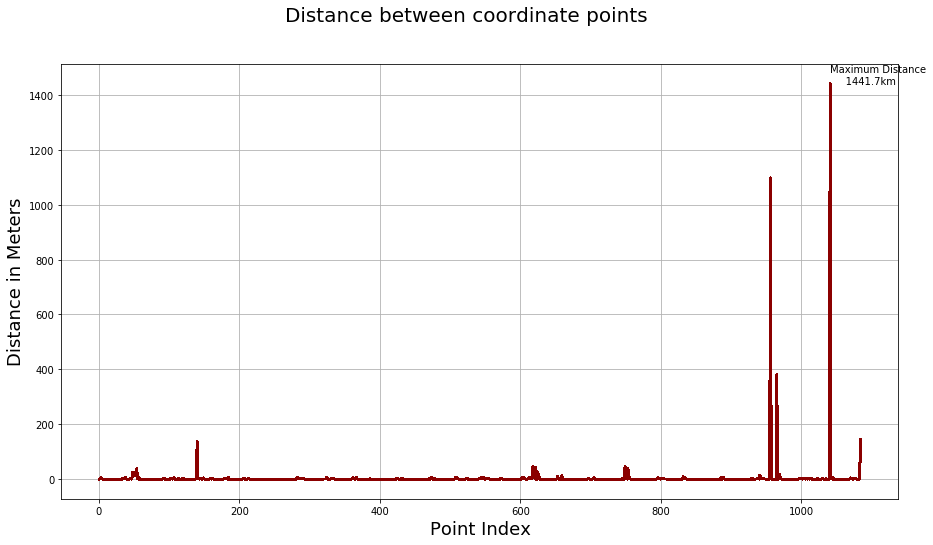

In [81]:
fig = plt.figure(figsize=(15, 8))
line, = plt.plot(x,y)
line.set_antialiased(False)
plt.setp(line, color = "darkred", linewidth=2)
fig.suptitle("Distance between coordinate points", fontsize=20)
plt.xlabel("Point Index", fontsize=18)
plt.ylabel("Distance in Meters", fontsize=18)
plt.grid()
ymax = max(y)
xpos = y.index(ymax)
xmax = x[xpos]

plt.annotate("Maximum Distance\n     {:.1f}km".format(ymax), xy=(xmax, ymax))
plt.show()

<h5> Looking at the maximum distance

In [82]:
max_dist = coordinates["distance in km"].max()
max_row = coordinates.iloc[coordinates["distance in km"].idxmax()]
city1, country1, all1 = get_city(max_row["last_latitude"], max_row["last_longitude"])
city2, country2, all2 = get_city(max_row["latitude"], max_row["longitude"])
print("Maximum distance between two consecutive coordinate points is {:.2f}km".format(coordinates["distance in km"].max()))
print("This is the distance between {} ({}) and {} ({})".format(city1, country1, city2, country2))

Maximum distance between two consecutive coordinate points is 1441.70km
This is the distance between Mainland Finland (Finland) and Vienna (Austria)


<h5>Creating the graph of the time between records

In [83]:
hours = coordinates["interval"].dt.days * 24 + coordinates["interval"].dt.seconds/3600
hours = hours.fillna(0)
hours = hours.tolist()
x = [i for i in range(1,len(hours)+1)]

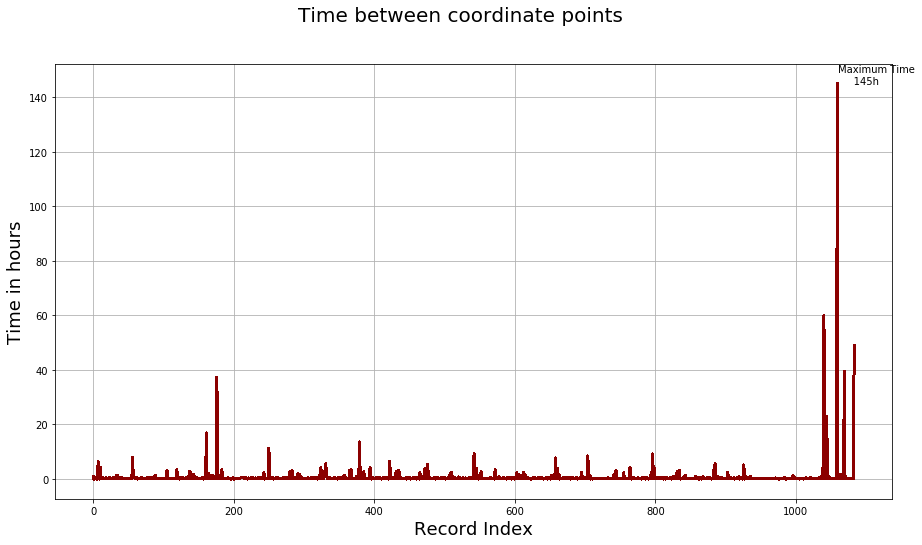

In [84]:
fig = plt.figure(figsize=(15, 8))
line, = plt.plot(hours)
line.set_antialiased(False)
plt.setp(line, color = "darkred", linewidth=2)
fig.suptitle("Time between coordinate points", fontsize=20)
plt.xlabel("Record Index", fontsize=18)
plt.ylabel("Time in hours", fontsize=18)
plt.grid()
ymax = max(hours)
xpos = hours.index(ymax)
xmax = x[xpos]

plt.annotate("Maximum Time\n     {:.0f}h".format(ymax), xy=(xmax, ymax))
plt.show()

<h5>Looking at the maximum time between records

In [85]:
max_time = coordinates["interval"].max().days * 24 + coordinates["interval"].max().seconds/3600
max_row = coordinates.iloc[coordinates["interval"].idxmax()]
city1, country1, all1 = get_city(max_row["last_latitude"], max_row["last_longitude"])
city2, country2, all2 = get_city(max_row["latitude"], max_row["longitude"])
print("Maximum time between two consecutive coordinate points is {:.0f} hours or {:.1f} days.".format(max_time, max_time/24))
print("This difference occured between {} ({}) and {} ({})".format(city1, country1, city2, country2))
print("The distance between the points is: {:.2f} km".format(max_row["distance in km"]))

Maximum time between two consecutive coordinate points is 145 hours or 6.0 days.
This difference occured between Vienna (Austria) and Vienna (Austria)
The distance between the points is: 0.01 km


<h5>Creating a graph of the average speed between the records

In [86]:
coordinates["hours since last record"] = coordinates["interval"].dt.days * 24 + coordinates["interval"].dt.seconds/3600
coordinates["avg_speed"] = coordinates["distance in km"]/coordinates["hours since last record"]
avg_speed = coordinates["avg_speed"].fillna(0) #NaN values occur because of division by 0
avg_speed = avg_speed.tolist()
x = [i for i in range(1,len(avg_speed)+1)]

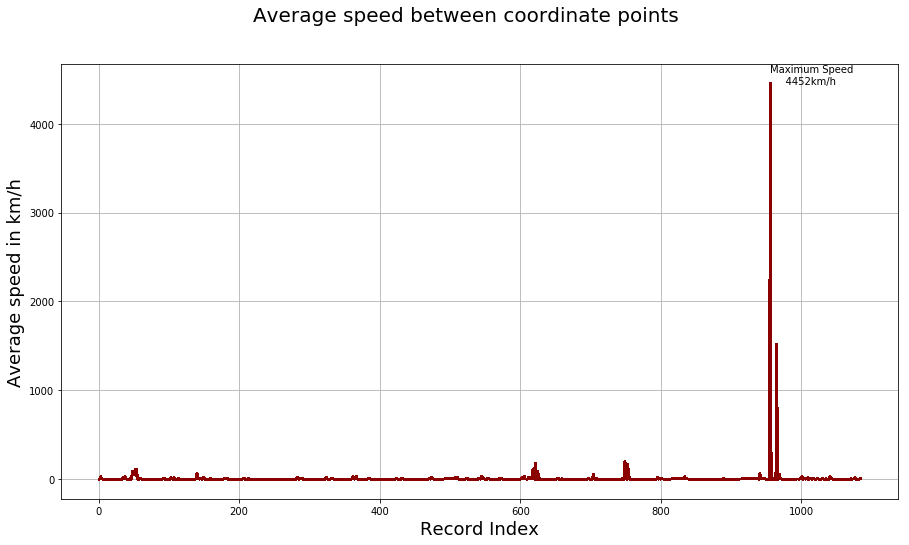

In [87]:
fig = plt.figure(figsize=(15, 8))
line, = plt.plot(x, avg_speed)
line.set_antialiased(False)
plt.setp(line, color = "darkred", linewidth=2)
fig.suptitle("Average speed between coordinate points", fontsize=20)
plt.xlabel("Record Index", fontsize=18)
plt.ylabel("Average speed in km/h", fontsize=18)
plt.grid()
xmax = max(distance)
ind = distance.idxmax()

ymax = max(avg_speed)
xpos = avg_speed.index(ymax)
xmax = x[xpos]

plt.annotate("Maximum Speed\n     {:.0f}km/h".format(ymax), xy=(xmax, ymax))
plt.show()

<h5>Looking at the maximum average speed

In [88]:
max_speed = coordinates["avg_speed"].max()
max_row = coordinates.iloc[coordinates["avg_speed"].idxmax()]
city1, country1, all1 = get_city(max_row["last_latitude"], max_row["last_longitude"])
city2, country2, all2 = get_city(max_row["latitude"], max_row["longitude"])
print("Maximum distance/time between two consecutive coordinate points is {:.0f} km/h.".format(max_speed))
print("This difference occured between {} ({}) and {} ({})".format(city1, country1, city2, country2))
print("The distance between the points is: {} km".format(max_row["distance in km"]))

Maximum distance/time between two consecutive coordinate points is 4452 km/h.
This difference occured between Lower Austria (Austria) and Vidzeme (Latvia)
The distance between the points is: 1098.0670514489989 km


In [89]:
coordinates[["latitude", "longitude", "last_latitude", "last_longitude", "time", "last_time", "interval", "distance in km", "avg_speed"]].sort_values(by = "avg_speed", ascending = False).head(5)

,latitude,longitude,last_latitude,last_longitude,time,last_time,interval,distance in km,avg_speed
955,56.923855,23.979012,48.119876,16.556954,2018-10-25 19:18:22.329,2018-10-25 19:03:33.372,00:14:48.957000,1098.067051,4451.623182
964,60.316045,24.970702,56.924211,23.984607,2018-10-25 21:32:54.418,2018-10-25 21:17:49.910,00:15:04.508000,381.200922,1518.056768
748,47.233158,15.993249,47.021636,15.483339,2018-10-21 12:06:30.378,2018-10-21 11:52:53.787,00:13:36.591000,45.152824,199.203635
621,47.093801,15.832156,47.371224,16.222036,2018-10-18 20:46:33.220,2018-10-18 20:31:53.093,00:14:40.127000,42.613237,174.326880
752,48.019620,16.326191,47.697504,16.130183,2018-10-21 13:09:28.458,2018-10-21 12:55:30.652,00:13:57.806000,38.663578,166.294958


It looks like the time zones are messed up, the highest two speeds were measured between Austria - Latvia and Latvia - Finland. Latvia should be one timezone ahead of Austria and the same as Finland.

In [90]:
print("calculated for row 955: ", 1098/0.25, "km/h")
print("one timezone different for row 955: ", 1098/(0.25+1), "km/h")
print("calculated for row 964: ", 381/0.25, "km/h")
print("one timezone different for row 964: ", 381/(0.25+1), "km/h")

calculated for row 955:  4392.0 km/h
one timezone different for row 955:  878.4 km/h
calculated for row 964:  1524.0 km/h
one timezone different for row 964:  304.8 km/h


In [91]:
coordinates.loc[(coordinates["latitude"] > 55) & (coordinates["latitude"] < 59)]

,latitude,longitude,timestamp,last_latitude,last_longitude,distance in km,time,last_time,interval,hours since last record,avg_speed
955,56.923855,23.979012,2018-10-25T19:18:22.329Z,48.119876,16.556954,1098.067051,2018-10-25 19:18:22.329,2018-10-25 19:03:33.372,00:14:48.957000,0.246667,4451.623182
956,56.923855,23.979012,2018-10-25T19:34:32.763Z,56.923855,23.979012,0.000000,2018-10-25 19:34:32.763,2018-10-25 19:18:22.329,00:16:10.434000,0.269444,0.000000
957,56.923855,23.979012,2018-10-25T19:48:37.365Z,56.923855,23.979012,0.000000,2018-10-25 19:48:37.365,2018-10-25 19:34:32.763,00:14:04.602000,0.234444,0.000000
958,56.923855,23.979012,2018-10-25T20:04:57.223Z,56.923855,23.979012,0.000000,2018-10-25 20:04:57.223,2018-10-25 19:48:37.365,00:16:19.858000,0.271944,0.000000
959,56.924211,23.984607,2018-10-25T20:18:46.225Z,56.923855,23.979012,0.341616,2018-10-25 20:18:46.225,2018-10-25 20:04:57.223,00:13:49.002000,0.230278,1.483493
960,56.924211,23.984607,2018-10-25T20:32:43.101Z,56.924211,23.984607,0.000000,2018-10-25 20:32:43.101,2018-10-25 20:18:46.225,00:13:56.876000,0.232222,0.000000
961,56.924211,23.984607,2018-10-25T20:51:23.449Z,56.924211,23.984607,0.000000,2018-10-25 20:51:23.449,2018-10-25 20:32:43.101,00:18:40.348000,0.311111,0.000000
962,56.924211,23.984607,2018-10-25T21:03:28.745Z,56.924211,23.984607,0.000000,2018-10-25 21:03:28.745,2018-10-25 20:51:23.449,00:12:05.296000,0.201389,0.000000
963,56.924211,23.984607,2018-10-25T21:17:49.910Z,56.924211,23.984607,0.000000,2018-10-25 21:17:49.910,2018-10-25 21:03:28.745,00:14:21.165000,0.239167,0.000000


Unfortunately, no GPS points were recorded on the way back.